In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import numpy as np

from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

In [2]:
# Initialize IRIS client
client = Client("IRIS")

# set our date range
starttime = UTCDateTime('2018-4-1')
endtime = UTCDateTime('2018-8-31')

POHA = client.get_stations(network="IU", station="POHA", 
                           starttime=starttime, endtime=endtime,
                          level='response')

In [3]:
events = client.get_events(starttime=starttime, endtime=endtime, 
                  latitude=19.76, longitude=-155.53,
                  maxradius=1, minmagnitude=1.5
                 )

In [9]:
events.write('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml', format='QUAKEML')

In [8]:
events = obspy.read_events('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.xml', format='QUAKEML')

In [7]:
class ArrivalTime():
    def __init__(self, station):
        self.stalat = station.latitude
        self.stalong = station.longitude
        #self.stadepth = station.depth
        self.model = TauPyModel(model="iasp91")
        
    def calc_arrival_time(self, event):
        eventlat = event.origins[0].latitude
        eventlong = event.origins[0].longitude
        eventdepth = event.origins[0].depth/1000
        
        arr = self.model.get_travel_times_geo(source_depth_in_km=np.abs(eventdepth), 
                                              source_latitude_in_deg=eventlat , 
                                              source_longitude_in_deg=eventlong, 
                                              receiver_latitude_in_deg=self.stalat, 
                                              receiver_longitude_in_deg=self.stalong, 
                                              #phase_list=['p']
                                              )
        return arr

In [9]:
Arrival = ArrivalTime(POHA[0].stations[0])
arrival_times = [Arrival.calc_arrival_time(event)[0].time for event in events]

C:\Users\Nate\Anaconda3\lib\site-packages\obspy\taup\tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


In [ ]:
stream = obspy.Stream()

for i,event in enumerate(events):
    starttime = event.origins[0].time + arrival_times[i]
    wave = client.get_waveforms("IU", "POHA", "00", "BHZ", starttime, starttime+40)
    stream += wave
    if i%100==0:
        print('Downloaded {}'.format(i))

In [11]:
stream.write('hawaii_Apr-Aug-2018_mag1.5_POHA_catalog.mseed')

In [ ]:
stream

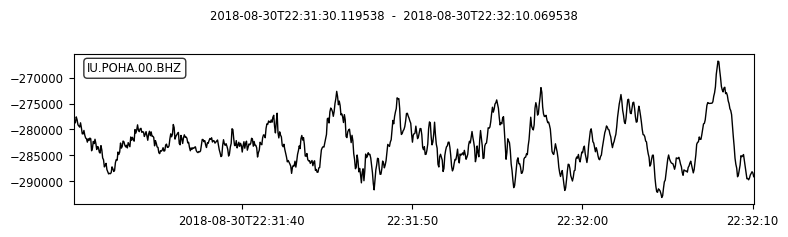

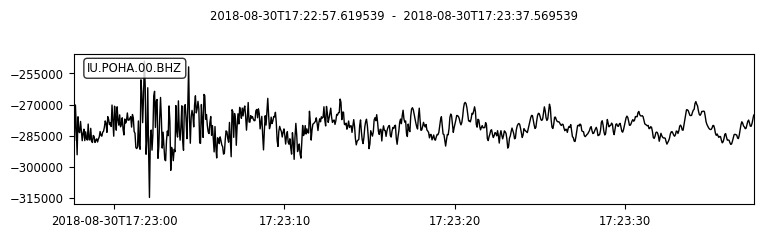

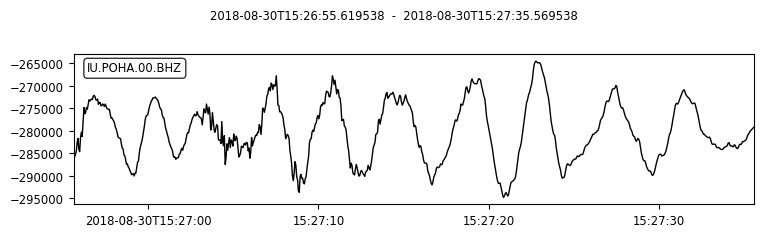

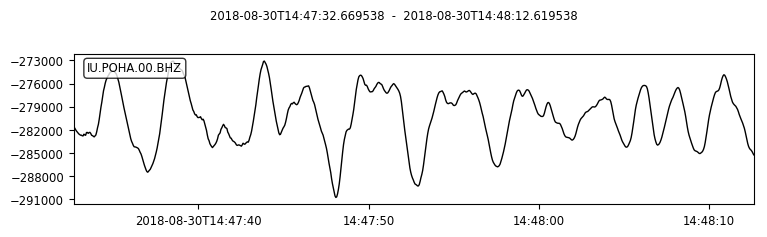

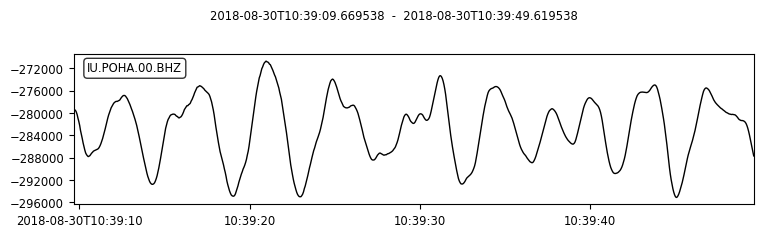

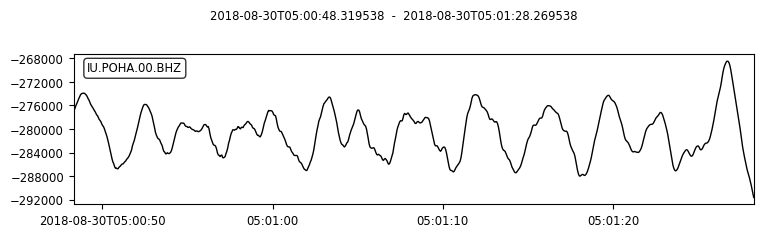

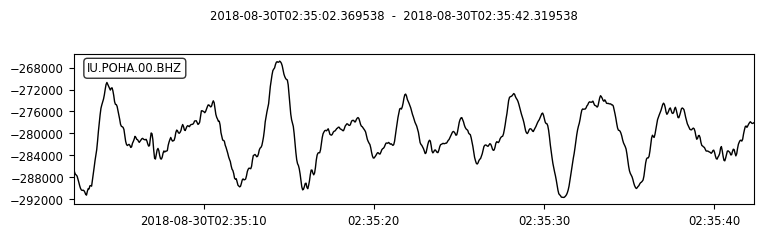

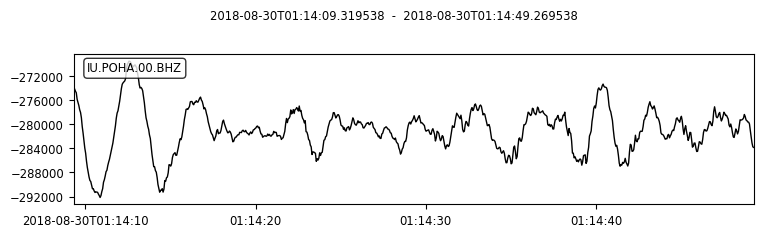

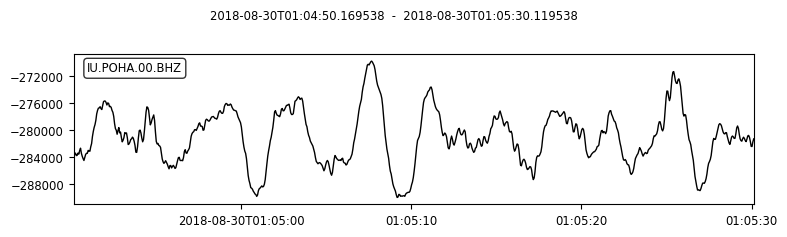

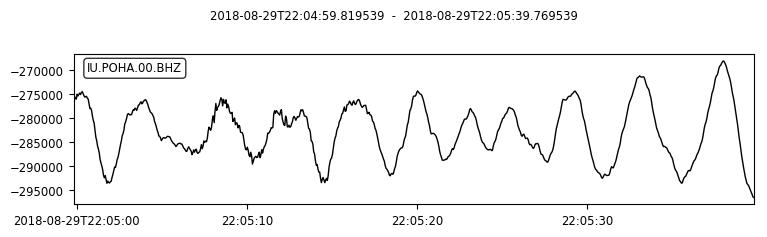

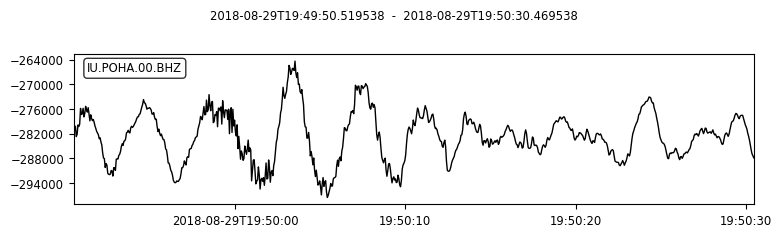

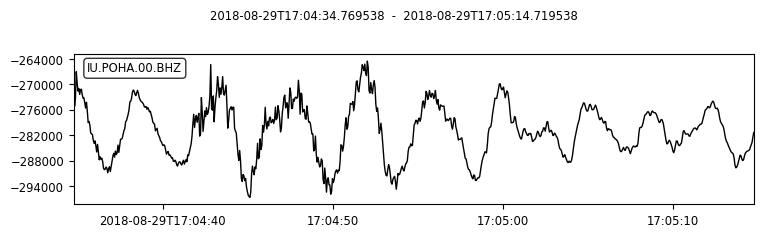

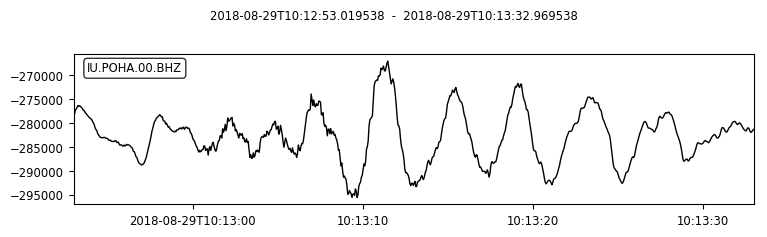

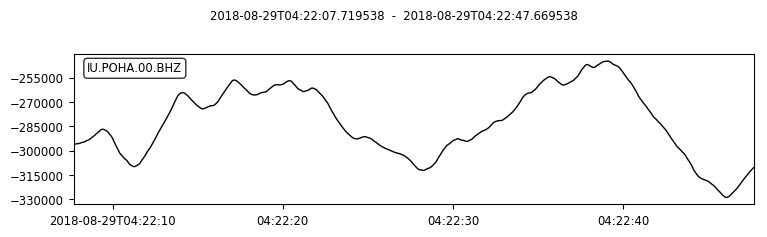

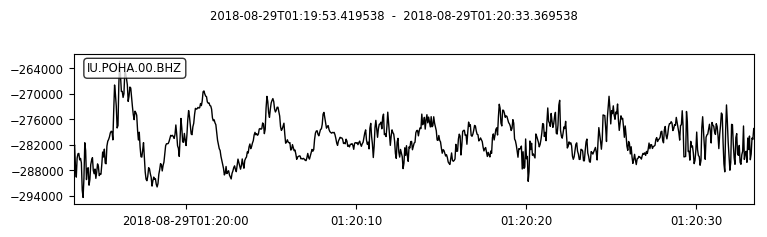

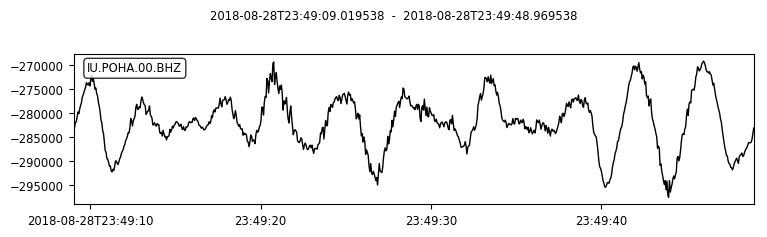

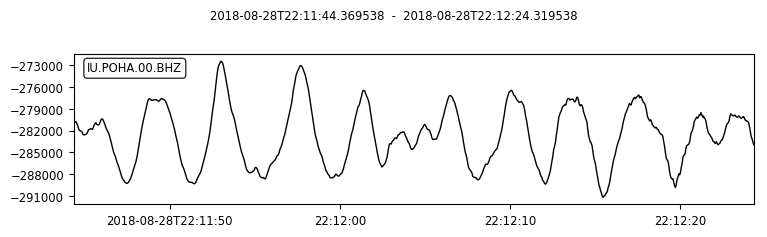

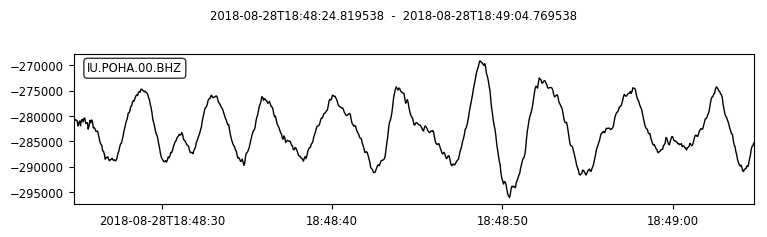

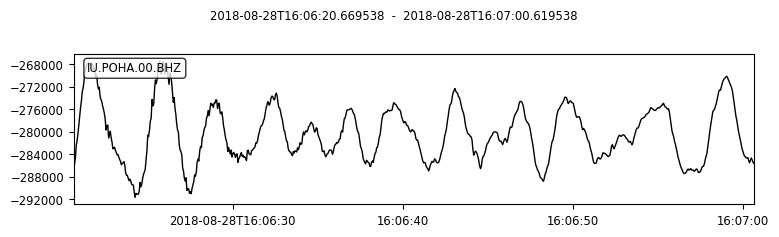

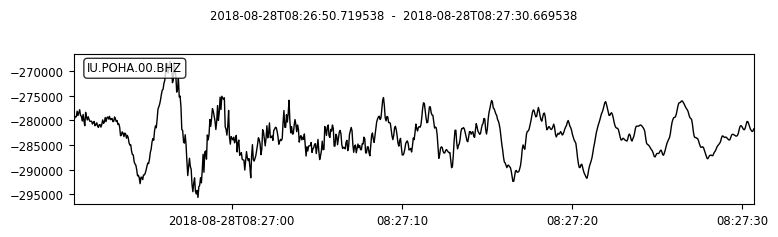

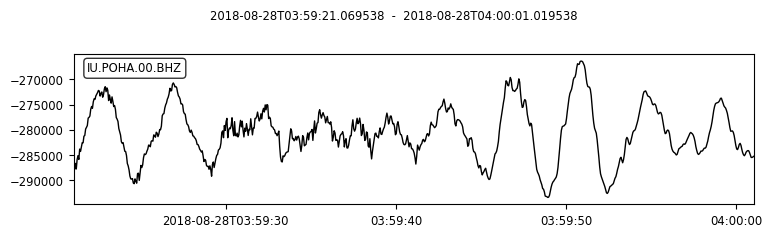

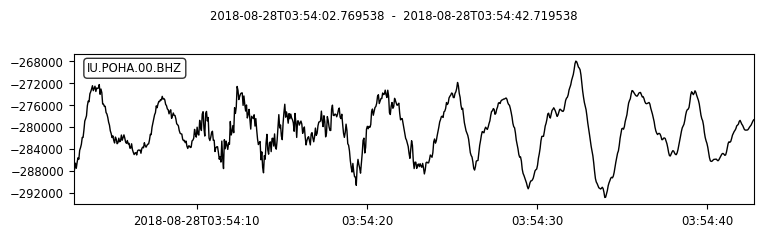

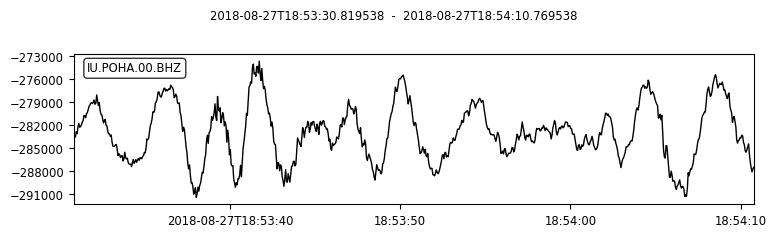

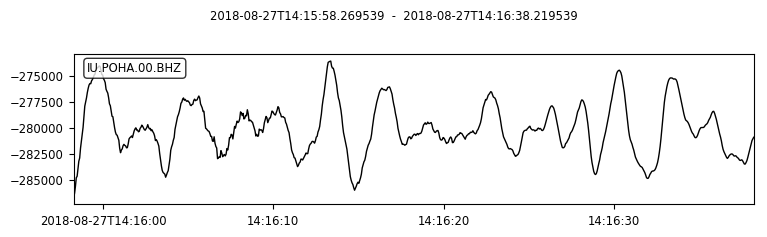

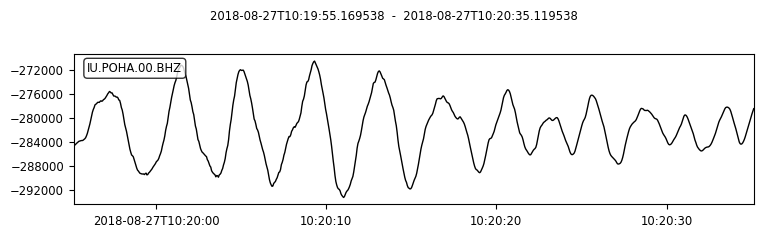

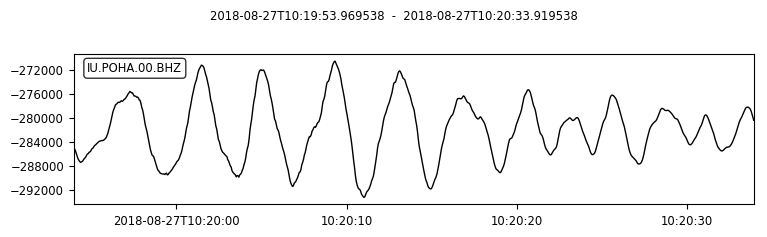

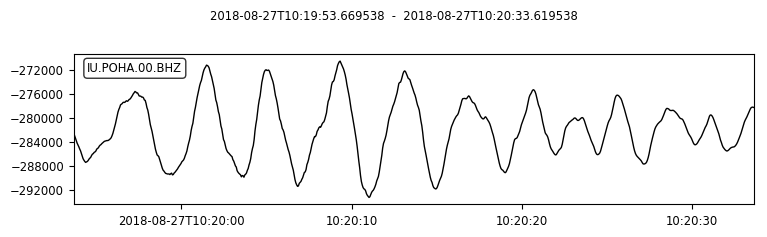

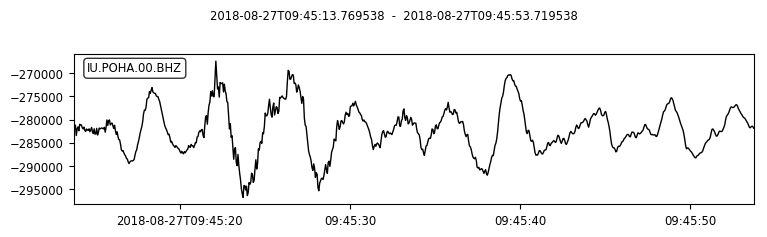

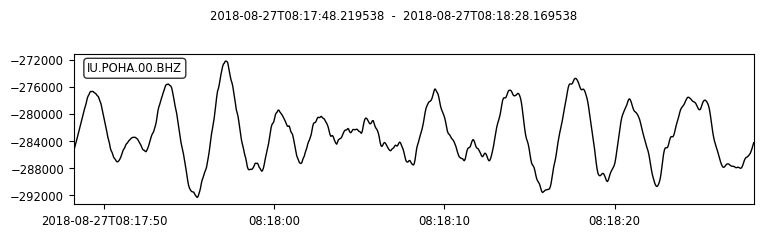

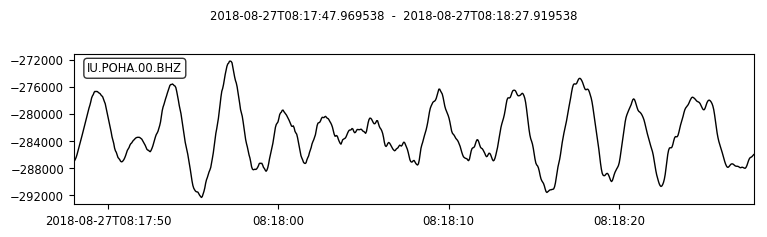

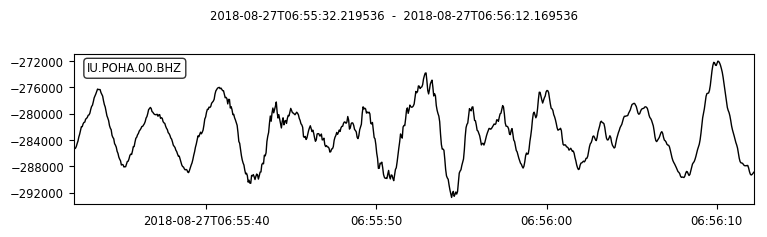

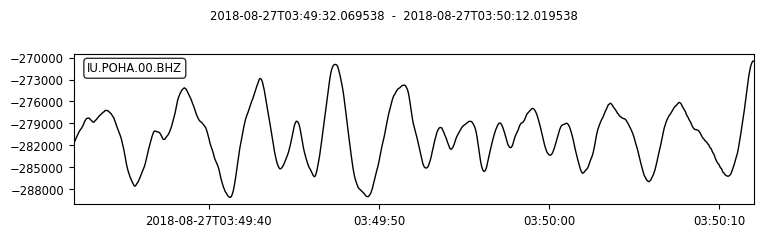

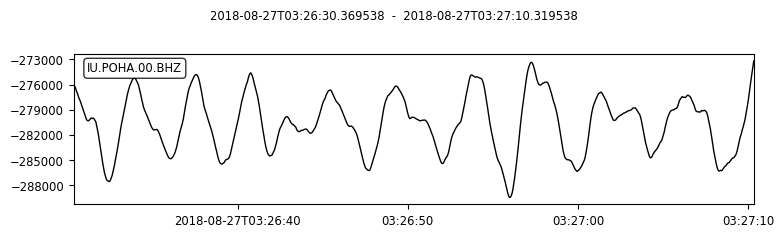

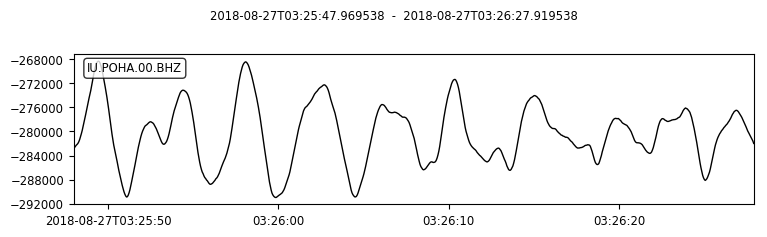

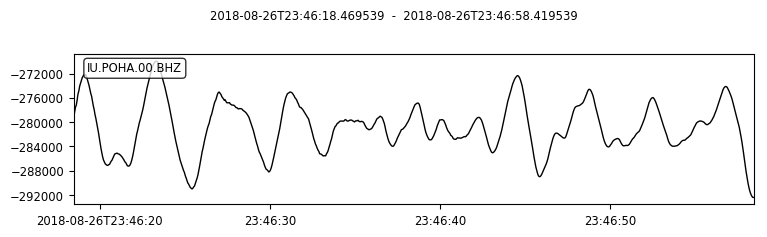

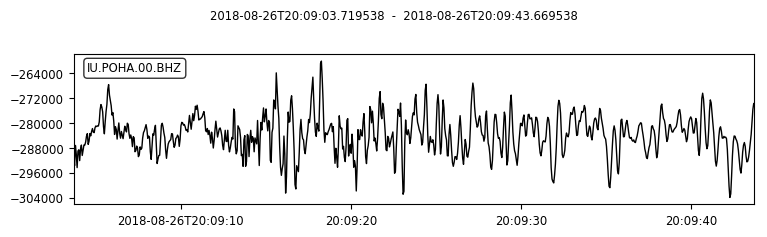

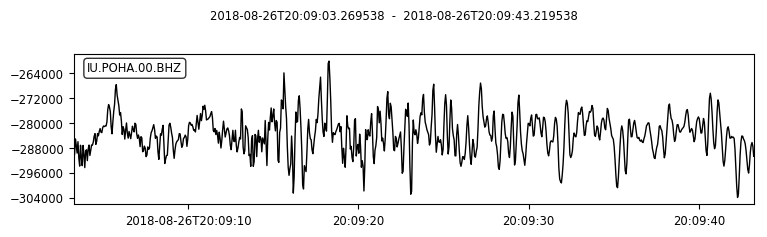

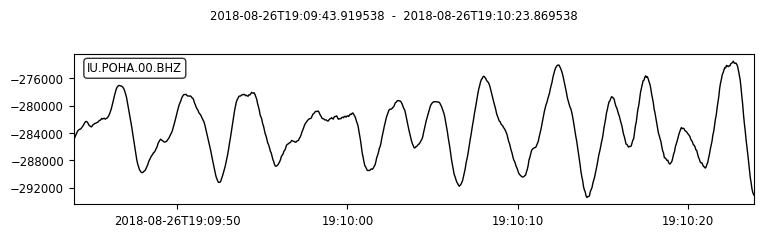

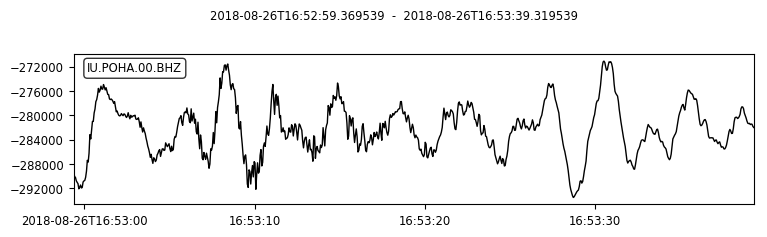

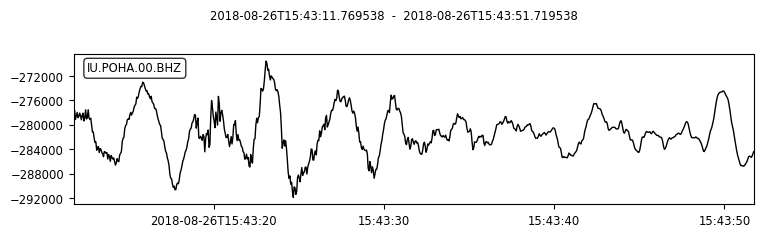

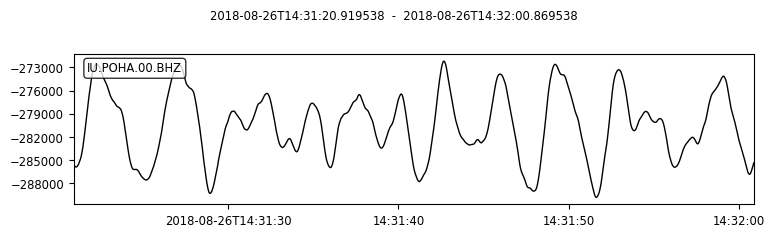

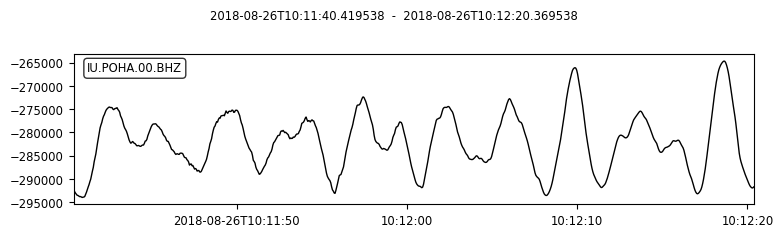

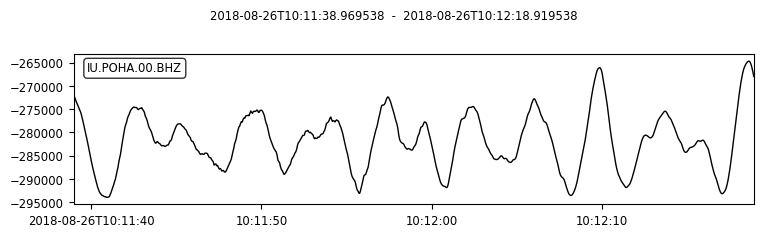

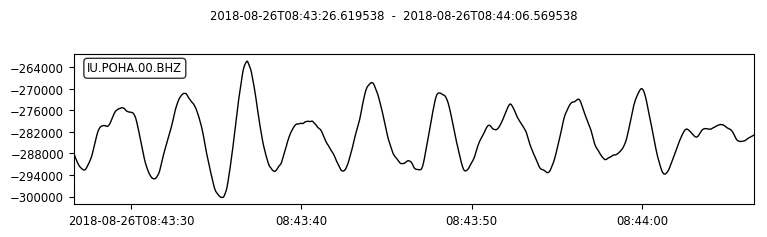

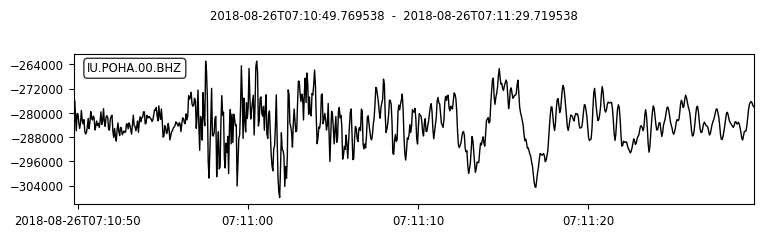

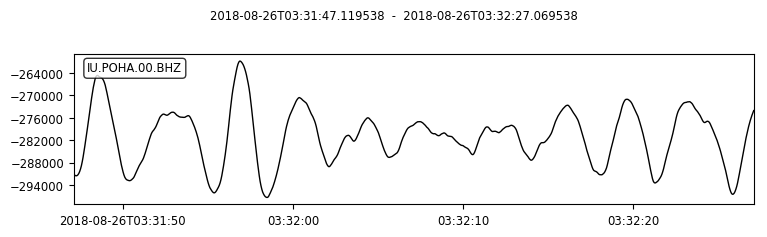

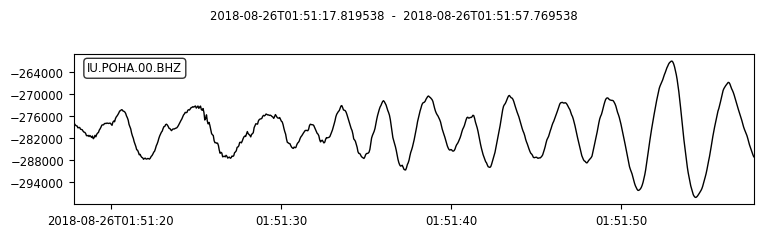

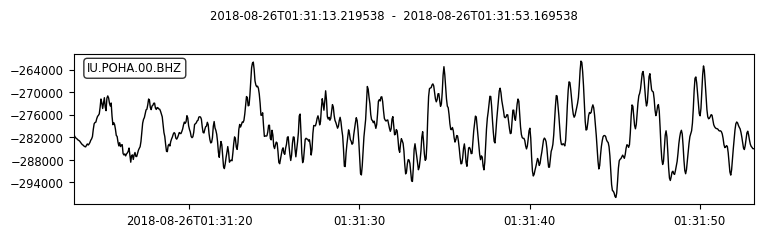

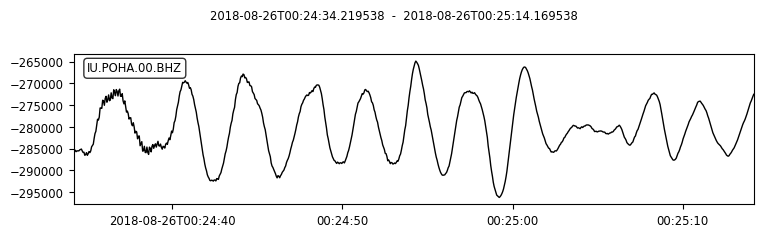

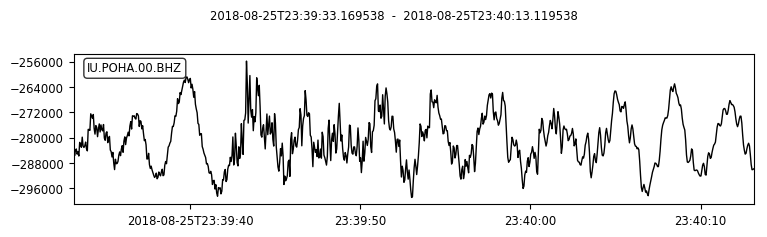

In [12]:
for st in stream[:5]:
    st.plot()

In [13]:
strcopy = stream.copy()

In [14]:
strcopy.remove_response(POHA)

41476 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-08-30T22:31:30.119538Z - 2018-08-30T22:32:10.069538Z | 20.0 Hz, 800 samples
...
(41474 other traces)
...
IU.POHA.00.BHZ | 2018-04-01T06:52:24.269538Z - 2018-04-01T06:53:04.219538Z | 20.0 Hz, 800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [15]:
strcopy.filter('bandpass', freqmin=3, freqmax=8, corners=2, zerophase=True)

41476 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-08-30T22:31:30.119538Z - 2018-08-30T22:32:10.069538Z | 20.0 Hz, 800 samples
...
(41474 other traces)
...
IU.POHA.00.BHZ | 2018-04-01T06:52:24.269538Z - 2018-04-01T06:53:04.219538Z | 20.0 Hz, 800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [17]:
strcopy.normalize()

41476 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-08-30T22:31:30.119538Z - 2018-08-30T22:32:10.069538Z | 20.0 Hz, 800 samples
...
(41474 other traces)
...
IU.POHA.00.BHZ | 2018-04-01T06:52:24.269538Z - 2018-04-01T06:53:04.219538Z | 20.0 Hz, 800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [1]:
for st in strcopy[:5]:
    st.plot()

NameError: name 'strcopy' is not defined

In [35]:
events[0]

Event:	2018-08-30T22:31:16.570000Z | +19.455, -154.854 | 2.52 Ml

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=10942311")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=34316286")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=189355539")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

In [63]:
origin = events[0].origins[0]

arr = model.get_travel_times_geo(source_depth_in_km= origin.depth, 
                           source_latitude_in_deg=origin.latitude , 
                           source_longitude_in_deg=origin.longitude, 
                           receiver_latitude_in_deg=POHA[0].stations[0].latitude, 
                           receiver_longitude_in_deg=POHA[0].stations[0].longitude, 
                           phase_list=['p']
                          )

In [64]:
arr[0]

In [99]:
class ArrivalTiem():
    def __init__(self, station):
        self.stalat = station.latitude
        self.stalong = station.longitude
        #self.stadepth = station.depth
        self.model = TauPyModel(model="iasp91")
        
    def calc_arrival_time(self, event):
        eventlat = event.origins[0].latitude
        eventlong = event.origins[0].longitude
        eventdepth = event.origins[0].depth/1000
        
        arr = self.model.get_travel_times_geo(source_depth_in_km=np.abs(eventdepth), 
                                              source_latitude_in_deg=eventlat , 
                                              source_longitude_in_deg=eventlong, 
                                              receiver_latitude_in_deg=self.stalat, 
                                              receiver_longitude_in_deg=self.stalong, 
                                              #phase_list=['p']
                                              )
        return arr

In [100]:
Arrival = ArrivalTiem(POHA[0].stations[0])

In [106]:
arrival_times

[13.549510390275904,
 5.5989922189435148,
 10.173917133830155,
 8.4929629311912311,
 12.03472184389797,
 8.1440766022674147,
 8.0979895626103691,
 7.9314624900070356,
 8.0382360527130974,
 11.139686729064014,
 10.70990109265758,
 9.9162914789257872,
 11.008800622367241,
 7.7054212845633732,
 7.7730281473995415,
 8.1264785165560234,
 8.1598804985444797,
 11.559123889673852,
 6.3431306447738027,
 6.8636602641150084,
 12.050384591014163,
 12.133780683578973,
 11.958504834264467,
 12.622092725456433,
 7.7616899317367825,
 7.6944494999926043,
 7.5677868256178673,
 10.57681026925132,
 8.1247025456074731,
 8.1389892019701264,
 13.229686688330913,
 8.1142509091411767,
 8.060366634755372,
 7.6022853507772954,
 10.573665276365793,
 12.418992172048158,
 13.395772073082277,
 8.0278495004437573,
 11.396936792905302,
 10.686591596234011,
 8.0674619376236585,
 7.7885213550650647,
 7.5544424833518313,
 7.782875797894822,
 10.778238536278568,
 8.3246655501890636,
 12.230738350639612,
 6.375048477674844

In [107]:
events[2].origins[0].depth

-130.0

In [95]:
sum([1 for x in events if x.origins[0].depth<0])

5807

In [98]:
np.abs(-1)

1

In [117]:
event.origins[0].time + arrival_times[i]

2018-08-30T22:31:30.119510Z

In [20]:
arrival_times

[13.549510390275904,
 5.5989922189435148,
 10.173917133830155,
 8.4929629311912311,
 12.03472184389797,
 8.1440766022674147,
 8.0979895626103691,
 7.9314624900070356,
 8.0382360527130974,
 11.139686729064014,
 10.70990109265758,
 9.9162914789257872,
 11.008800622367241,
 7.7054212845633732,
 7.7730281473995415,
 8.1264785165560234,
 8.1598804985444797,
 11.559123889673852,
 6.3431306447738027,
 6.8636602641150084,
 12.050384591014163,
 12.133780683578973,
 11.958504834264467,
 12.622092725456433,
 7.7616899317367825,
 7.6944494999926043,
 7.5677868256178673,
 10.57681026925132,
 8.1247025456074731,
 8.1389892019701264,
 13.229686688330913,
 8.1142509091411767,
 8.060366634755372,
 7.6022853507772954,
 10.573665276365793,
 12.418992172048158,
 13.395772073082277,
 8.0278495004437573,
 11.396936792905302,
 10.686591596234011,
 8.0674619376236585,
 7.7885213550650647,
 7.5544424833518313,
 7.782875797894822,
 10.778238536278568,
 8.3246655501890636,
 12.230738350639612,
 6.375048477674844

In [ ]:
events.plot(projection='local')

In [18]:
sample = obspy.Catalog([events[i] for i in np.random.randint(low=1, high=len(events)+1, size=1000)])

In [19]:
sample

1000 Event(s) in Catalog:
2018-07-19T14:26:55.350000Z | +19.413, -155.261 | 2.13 Ml
2018-06-26T14:22:38.070000Z | +19.425, -155.275 | 2.1 Ml
...
2018-06-27T01:54:47.250000Z | +19.406, -155.276 | 2.58 Ml
2018-05-09T12:54:37.640000Z | +19.171, -155.134 | 2.16 Md
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [ ]:
#f, ax = plt.subplots(1, figsize=(20,20))
_=sample.plot(projection='local', resolution='h', label=None)

In [36]:
from IPython.display import Image

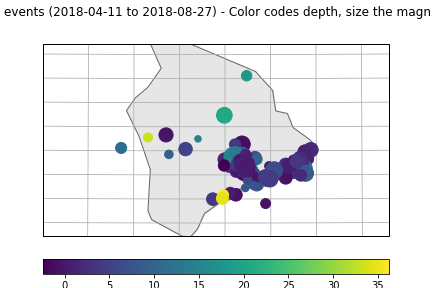

In [37]:
Image(filename='kilauea_quakes.png')